In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
#from matplotlib.mlab import PCA as mlabPCA
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [5]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user,postgres_pw,postgres_host,postgres_port,postgres_db))
lifex = pd.read_sql_query('select * from lifeexpectancy', con=engine)

engine.dispose()

lifex.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5



Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.


Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection?
For the missing values, discuss which technique would be the most suitable one in filling out these values.

Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

In [6]:
titles = {k:k.replace(k,k.strip()) for k in lifex.columns}
lifex.rename(columns=titles,inplace=True)

Missing Values

In [7]:
print(len(lifex))
lifex.isnull().sum()

2938


Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

In [8]:
correlation = lifex.corr()
correlation[['Population', 'Hepatitis B', 'GDP']]

,Population,Hepatitis B,GDP
Year,0.016969,0.104333,0.101620
Life expectancy,-0.021538,0.256762,0.461455
Adult Mortality,-0.013647,-0.162476,-0.296049
infant deaths,0.556801,-0.223566,-0.108427
Alcohol,-0.035252,0.087549,0.354712
percentage expenditure,-0.025662,0.016274,0.899373
Hepatitis B,-0.123321,1.000000,0.083903
Measles,0.265966,-0.120529,-0.076466
BMI,-0.072301,0.150380,0.301557
under-five deaths,0.544423,-0.233126,-0.112081


In [9]:
lifex = lifex.sort_values(by=['Country','Year'])
lifex.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
15,Afghanistan,2000,Developing,54.8,321.0,88,0.01,10.424960,62.0,6532,12.2,122,24.0,8.20,24.0,0.1,114.560000,293756.0,2.3,2.5,0.338,5.5
14,Afghanistan,2001,Developing,55.3,316.0,88,0.01,10.574728,63.0,8762,12.6,122,35.0,7.80,33.0,0.1,117.496980,2966463.0,2.1,2.4,0.340,5.9
13,Afghanistan,2002,Developing,56.2,3.0,88,0.01,16.887351,64.0,2486,13.0,122,36.0,7.76,36.0,0.1,187.845950,21979923.0,19.9,2.2,0.341,6.2
12,Afghanistan,2003,Developing,56.7,295.0,87,0.01,11.089053,65.0,798,13.4,122,41.0,8.82,41.0,0.1,198.728544,2364851.0,19.7,19.9,0.373,6.5
11,Afghanistan,2004,Developing,57.0,293.0,87,0.02,15.296066,67.0,466,13.8,120,5.0,8.79,5.0,0.1,219.141353,24118979.0,19.5,19.7,0.381,6.8


In [10]:
#how many years worth of data per country?
np.unique(lifex['Year'])

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015])

In [11]:
# For each country, fill row of first year using forward fill
index_list = [lifex[lifex['Country']==country].index[0] for country in np.unique(lifex['Country'])] #if lifex.loc[index].isnull().sum() != 0]

for index in index_list:
    if lifex.loc[index].isnull().sum() != 0:
        lifex.loc[index].fillna(method='ffill',inplace=True)
print(lifex.isnull().sum())
# Now fill the rest of the dataset using backward fill
lifex.fillna(method='backfill',inplace=True)

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64


Outliers

In [12]:

# Re-use the correlation variable
correlation = lifex.corr()
correlation = correlation.sort_values(by=['Life expectancy'], ascending=False)

correlation[['Life expectancy']]

,Life expectancy
Life expectancy,1.000000
Schooling,0.681763
Income composition of resources,0.670519
BMI,0.545069
Diphtheria,0.476122
Polio,0.461525
GDP,0.433047
percentage expenditure,0.381277
Alcohol,0.367903
Hepatitis B,0.262452


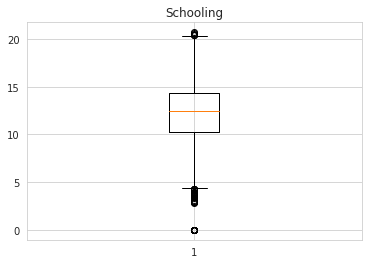

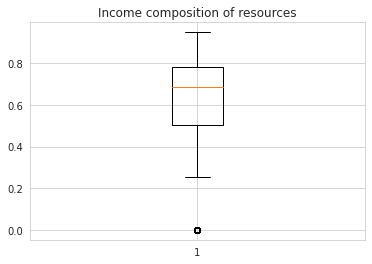

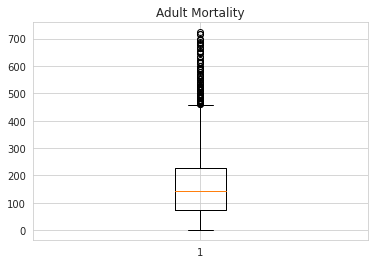

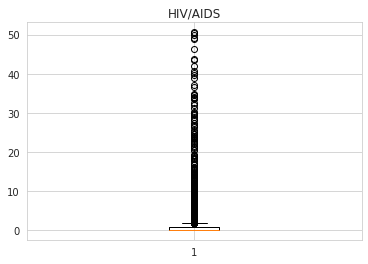

In [13]:
# Plot each of the 4 variables
plt.boxplot(lifex['Schooling'])
plt.title('Schooling')
plt.show()
plt.boxplot(lifex['Income composition of resources'])
plt.title('Income composition of resources')
plt.show()
plt.boxplot(lifex['Adult Mortality'])
plt.title('Adult Mortality')
plt.show()
plt.boxplot(lifex['HIV/AIDS'])
plt.title('HIV/AIDS')
plt.show()

In [14]:

# Perform winsorization on variables with outliers
lifex['Adult Mortality'] = winsorize(lifex['Adult Mortality'],limits=[0.05,.09]) 
lifex['HIV/AIDS'] = winsorize(lifex['HIV/AIDS'],limits=[0.05,.20])

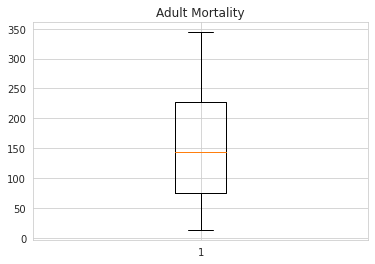

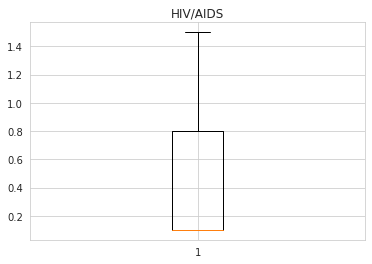

In [15]:
# Re-plot variables with outliers
plt.boxplot(lifex['Adult Mortality'])
plt.title('Adult Mortality')
plt.show()
plt.boxplot(lifex['HIV/AIDS'])
plt.title('HIV/AIDS')
plt.show()

In [16]:
lifex.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2937.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2937.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.217325,156.242682,30.303948,4.627184,738.251295,74.845133,2419.592240,38.464704,42.035739,82.307692,5.896261,82.075221,0.469197,6742.810123,1.323592e+07,4.810177,4.839925,0.635130,12.124438
std,4.613841,9.524432,102.405890,117.926501,4.064449,1987.914858,29.398675,11467.272489,20.000438,160.445548,23.636677,2.514318,23.917022,0.569172,13319.145946,5.625230e+07,4.407094,4.495764,0.208359,3.341817
min,2000.000000,36.300000,13.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.910000,4.685343,65.000000,0.000000,19.400000,0.000000,77.000000,4.230000,78.000000,0.100000,445.617074,2.581402e+05,1.600000,1.500000,0.503250,10.300000
50%,2008.000000,72.050000,144.000000,3.000000,3.760000,64.912906,88.000000,17.000000,43.900000,4.000000,93.000000,5.710000,93.000000,0.100000,1668.162731,1.531221e+06,3.300000,3.300000,0.686000,12.500000
75%,2012.000000,75.700000,228.000000,22.000000,7.800000,441.534144,96.000000,360.250000,56.300000,28.000000,97.000000,7.470000,97.000000,0.800000,5435.877542,6.675078e+06,7.100000,7.200000,0.782000,14.300000
max,2015.000000,89.000000,344.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.600000,99.000000,1.500000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


Univariate & Multivariate Analysis

In [17]:
# Re-use the correlation variable
correlation = lifex.corr()
correlation = correlation.sort_values(by=['Schooling'], ascending=False)

correlation[['Schooling']]

,Schooling
Schooling,1.000000
Income composition of resources,0.803874
Life expectancy,0.681763
BMI,0.462554
Alcohol,0.452774
GDP,0.419800
Polio,0.393024
Diphtheria,0.392231
percentage expenditure,0.364477
Total expenditure,0.216921


In [18]:
lifex['Schooling'].describe()

count    2938.000000
mean       12.124438
std         3.341817
min         0.000000
25%        10.300000
50%        12.500000
75%        14.300000
max        20.700000
Name: Schooling, dtype: float64

In [19]:
# Re-use the correlation variable
correlation = lifex.corr()
correlation = correlation.sort_values(by=['Income composition of resources'], ascending=False)

correlation[['Income composition of resources']]

,Income composition of resources
Income composition of resources,1.000000
Schooling,0.803874
Life expectancy,0.670519
BMI,0.444939
GDP,0.431424
Alcohol,0.392805
Diphtheria,0.378632
Polio,0.368601
percentage expenditure,0.360249
Year,0.231302


In [20]:

lifex['Income composition of resources'].describe()

count    2938.000000
mean        0.635130
std         0.208359
min         0.000000
25%         0.503250
50%         0.686000
75%         0.782000
max         0.948000
Name: Income composition of resources, dtype: float64

Adult Morality

In [21]:
# Re-use the correlation variable
correlation = lifex.corr()
correlation = correlation.sort_values(by=['Adult Mortality'], ascending=False)

correlation[['Adult Mortality']]

,Adult Mortality
Adult Mortality,1.000000
HIV/AIDS,0.572652
thinness 5-9 years,0.304113
thinness 1-19 years,0.298231
under-five deaths,0.104025
infant deaths,0.089100
Measles,0.031026
Population,-0.019497
Year,-0.052744
Total expenditure,-0.137283


In [22]:
lifex['Adult Mortality'].describe()

count    2938.000000
mean      156.242682
std       102.405890
min        13.000000
25%        74.000000
50%       144.000000
75%       228.000000
max       344.000000
Name: Adult Mortality, dtype: float64

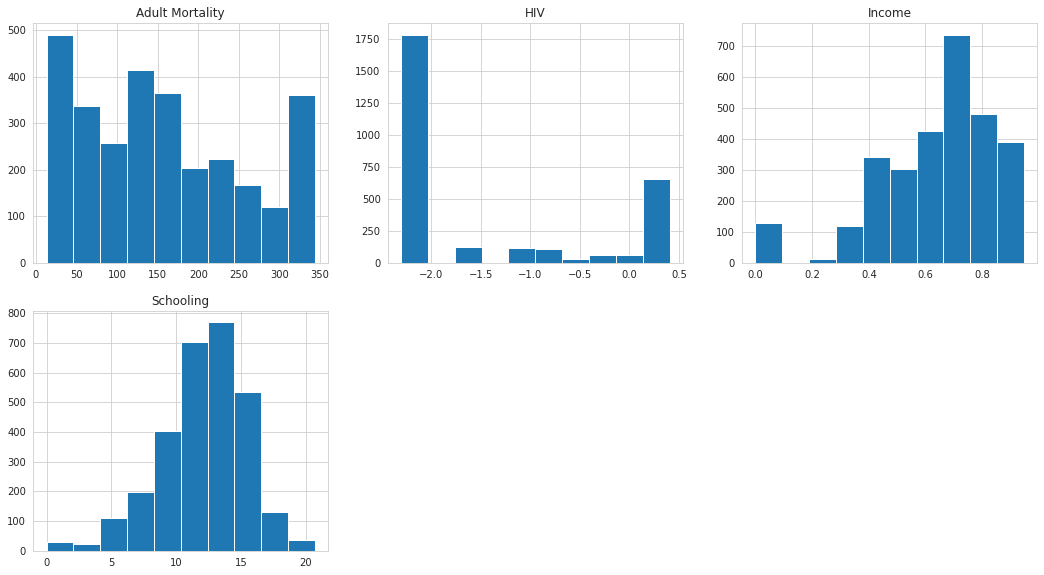

In [23]:
plt.figure(figsize=(18,15))

# histograms of the original data
plt.subplot(3, 3, 1)
plt.hist(lifex["Adult Mortality"])
plt.title("Adult Mortality")

plt.subplot(3, 3, 2)
plt.hist(np.log(lifex["HIV/AIDS"]))
plt.title("HIV")

plt.subplot(3, 3, 3)
plt.hist(lifex["Income composition of resources"])
plt.title("Income")

# histograms of the winsorized data
plt.subplot(3, 3, 4)
plt.hist(lifex["Schooling"])
plt.title("Schooling")

plt.show()

Multivariate Analysis

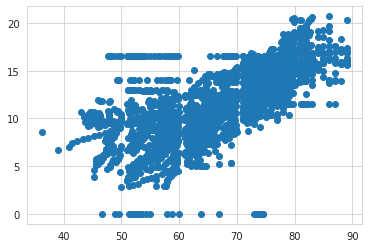

In [24]:
plt.scatter(lifex['Life expectancy'] ,lifex['Schooling'], )
plt.show()

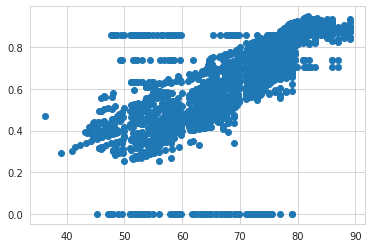

In [25]:

plt.scatter(lifex['Life expectancy'] ,lifex['Income composition of resources'], )
plt.show()

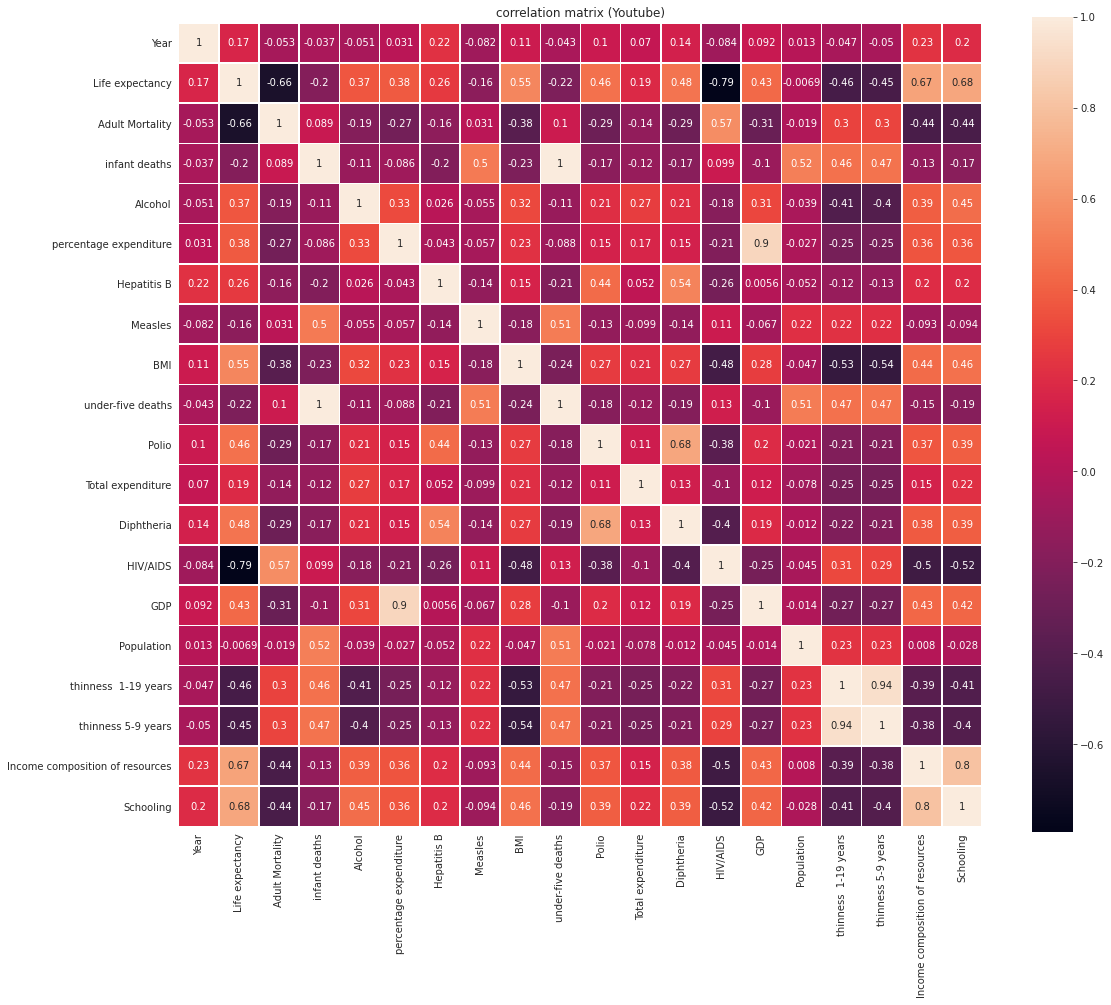

In [26]:
# make the correlation matrices.
corr_mat_lifex = lifex.corr()


# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(18,15))

plt.plot(1,1)
# draw the heatmap using seaborn.
sns.heatmap(corr_mat_lifex, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Youtube)")

plt.show()

# try to match the correlation numbers 
# to the scatterplots above to get a 
# sense of what each magnitude of 
# correlation can look like.

Feature Engineering

In [28]:

# Get rid of categorical columns
lifex_pca = lifex.drop(columns=['Country','Status'])
lifex_pca = lifex_pca.replace([np.inf, -np.inf], np.nan).dropna()

# PCA 
X = StandardScaler().fit_transform(lifex_pca.dropna())
sklearn_pca = PCA(n_components=2,svd_solver='full')
Y_sklearn = sklearn_pca.fit_transform(X)

In [29]:
Y_sklearn[:, 0] #pca1
Y_sklearn[:, 1] #pca2

array([-1.43380332, -1.24462898,  0.06708277, ..., -1.16535304,
       -1.14638614, -1.04206408])

In [30]:
len(sklearn_pca.components_)

2

PCA1 (First PCA component)

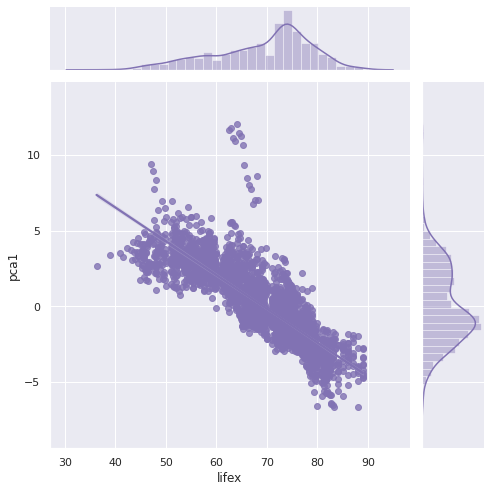

In [31]:
# plt.scatter(lifex['Life expectancy'][:len(Y_sklearn[:, 0])],Y_sklearn[:, 0])
temp_df = pd.DataFrame({'lifex':lifex_pca['Life expectancy'],'pca1':Y_sklearn[:, 0],'pca2':Y_sklearn[:, 1]})
# temp_df
sns.set(style="darkgrid")

g = sns.jointplot('lifex', "pca1", data=temp_df, kind="reg", color="m", height=7)

PCA2 (Second PCA Component)

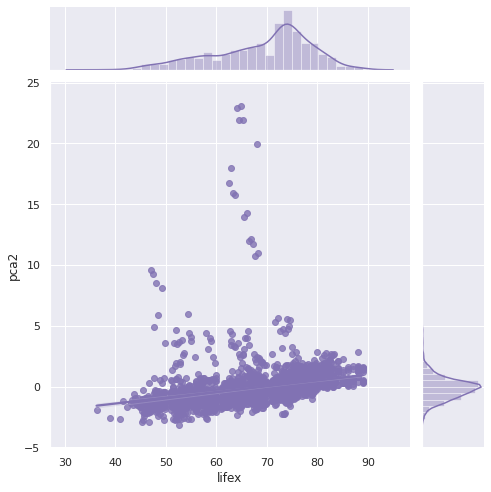

In [32]:
sns.set(style="darkgrid")

g = sns.jointplot('lifex', 'pca2', data=temp_df, kind="reg", color="m", height=7)